<a href="https://colab.research.google.com/github/NevesJulio/Exercicios_DL/blob/main/Exerc%C3%ADcioDL_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neurais Convolucionais

Neste notebook, investigaremos as Redes Neurais Convolucionais (Convolutional Neural Networks, ou CNNs), uma classe de arquiteturas de redes neurais que se tornou o padrão para tarefas de visão computacional. Diferentemente de um Perceptron Multicamadas (MLP), que trata a entrada como um vetor unidimensional, as CNNs são projetadas para processar dados que possuem uma topologia de grade, como imagens.

Para demonstrar sua eficácia, construiremos e treinaremos dois modelos para a tarefa de classificação de dígitos manuscritos do dataset MNIST:

1.  Um **modelo linear (MLP)**, que servirá como nossa baseline.
2.  Um **modelo convolucional (CNN)**, que emprega camadas convolucionais para aprender hierarquias de features espaciais.

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

## Dataset MNIST

Iniciamos preparando o dataset MNIST. Utilizaremos subconjuntos de 5.000 imagens para treino e 1.000 para validação. As imagens serão convertidas para tensores e normalizadas (média `0.1307`, desvio padrão `0.3081`) para otimizar a convergência do modelo.

In [5]:
transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

full_train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
full_val_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

train_indices = torch.arange(5000)
val_indices = torch.arange(1000)

train_subset = Subset(full_train_dataset, train_indices)
val_subset = Subset(full_val_dataset, val_indices)

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

print(f"Tamanho do subset de treino: {len(train_subset)} imagens")
print(f"Tamanho do subset de validação: {len(val_subset)} imagens")
print(f"Número de batches no train_loader: {len(train_loader)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.49MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.70MB/s]

Tamanho do subset de treino: 5000 imagens
Tamanho do subset de validação: 1000 imagens
Número de batches no train_loader: 79


In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate_model(model, val_loader, criterion):
    model.eval()  # Coloca o modelo em modo de avaliação
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_val_loss, accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        model.train()  # Modo de treinamento
        running_train_loss = 0.0

        # Loop de treinamento
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)

        # Avaliação ao final da época
        avg_val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

        # Armazena as métricas
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")

    print("Treinamento concluído.")
    return history

def plot_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot de Perda (Loss)
    ax1.plot(history['train_loss'], label='Perda de Treinamento')
    ax1.plot(history['val_loss'], label='Perda de Validação')
    ax1.set_title('Curvas de Perda')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Perda')
    ax1.legend()
    ax1.grid(True)

    # Plot de Acurácia
    ax2.plot(history['val_accuracy'], label='Acurácia de Validação', color='g')
    ax2.set_title('Curva de Acurácia')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Acurácia (%)')
    ax2.legend()
    ax2.grid(True)

    plt.show()

## Exercícios

### Exercício 1

Em vez de usar `nn.Sequential` para todo o modelo, uma prática mais comum e flexível é definir a arquitetura dentro de uma classe que herda de `nn.Module`. Isso nos permite organizar o modelo em seções lógicas.

Neste exercício, construa um modelo mais profundo, com três ou mais blocos convolucionais, e os organize em duas partes dentro de uma classe:
1.  Um extrator de features (`feature_extractor`), contendo as camadas convolucionais e de pooling.
2.  Um classificador (`classifier`), contendo as camadas `Flatten`, `Linear` e `Dropout`.

In [13]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), # 16, 28, 28
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 16, 14, 14
            nn.Conv2d(16, 32, 3, 1, 1), # 32, 14, 14
            nn.ReLU(),
            nn.MaxPool2d(2, 2)# 32, 7, 7
        )

        self.classification_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 10),
            nn.Dropout(p=0.5)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classification_head(x)
        return x






CNNModel(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification_head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=10, bias=True)
    (2): Dropout(p=0.5, inplace=False)
  )
)
Epoch [1/10], Train Loss: 1.4639, Val Loss: 0.4703, Val Accuracy: 88.90%
Epoch [2/10], Train Loss: 1.0747, Val Loss: 0.2916, Val Accuracy: 93.40%
Epoch [3/10], Train Loss: 0.9980, Val Loss: 0.2510, Val Accuracy: 93.90%
Epoch [4/10], Train Loss: 0.9431, Val Loss: 0.2014, Val Accuracy: 94.50%
Epoch [5/10], Train Loss: 0.9324, Val Loss: 0.1571, Val Accuracy: 95.30%
Epoch [6/10], Train Loss: 0.9242, Val Loss: 0.1264,

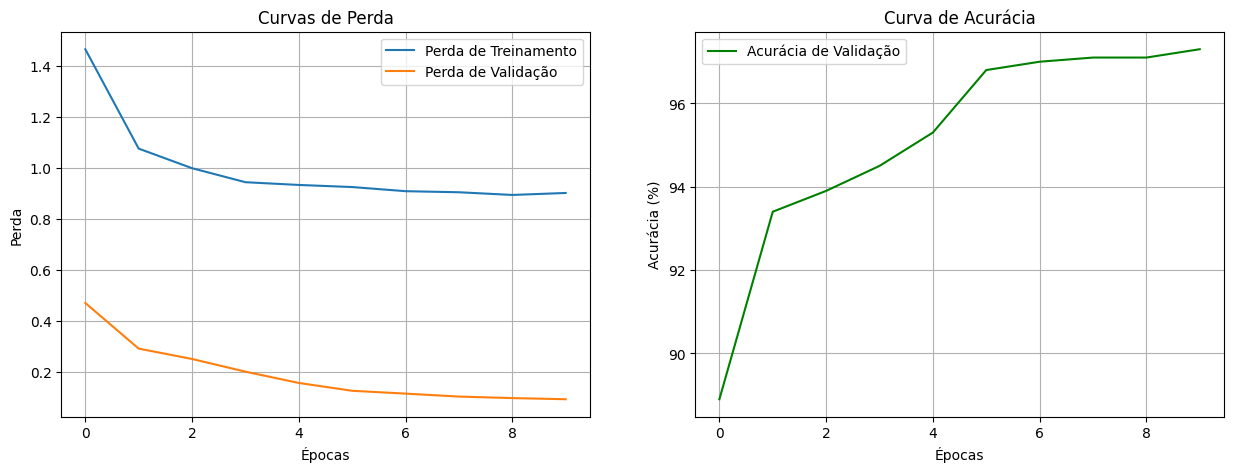

In [14]:
cnn_model = CNNModel()
print(cnn_model)
# Definindo o critério de perda e o otimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

# Treinando o modelo e coletando o histórico
cnn_history = train_model(cnn_model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Plotando as curvas de aprendizado
plot_curves(cnn_history)

### Exercício 2

Considere que ao invés do MNIST, os dados de entrada são imagens RGB no formato `(3, 32, 32)`. Implemente uma CNN para classificar essas imagens em 10 classes.